In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mesa import Agent, Model
from mesa.datacollection import DataCollector
import pandas as pd
import random

c:\Users\Alvin\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df_infl = pd.read_csv("inflationp2.csv")
INFLATON = [inflation / 12 for inflation in df_infl["inflation"] for _ in range(12)]
INFLATON

[0.122069388,
 0.122069388,
 0.122069388,
 0.122069388,
 0.122069388,
 0.122069388,
 0.122069388,
 0.122069388,
 0.122069388,
 0.122069388,
 0.122069388,
 0.122069388,
 0.13518524808333335,
 0.13518524808333335,
 0.13518524808333335,
 0.13518524808333335,
 0.13518524808333335,
 0.13518524808333335,
 0.13518524808333335,
 0.13518524808333335,
 0.13518524808333335,
 0.13518524808333335,
 0.13518524808333335,
 0.13518524808333335,
 0.009885594666666666,
 0.009885594666666666,
 0.009885594666666666,
 0.009885594666666666,
 0.009885594666666666,
 0.009885594666666666,
 0.009885594666666666,
 0.009885594666666666,
 0.009885594666666666,
 0.009885594666666666,
 0.009885594666666666,
 0.009885594666666666,
 0.10513193383333334,
 0.10513193383333334,
 0.10513193383333334,
 0.10513193383333334,
 0.10513193383333334,
 0.10513193383333334,
 0.10513193383333334,
 0.10513193383333334,
 0.10513193383333334,
 0.10513193383333334,
 0.10513193383333334,
 0.10513193383333334,
 0.177509167,
 0.177509167,


In [3]:
#data from https://fred.stlouisfed.org/series/REAINTRATREARAT10Y#0
#the data is the interest rate per month for all 120 months starting from 2013 till the end of 2023

df = pd.read_csv('data_interest_rate.csv')
df2 = df.drop([df.index[120]])
df3 = df2["interest_rate"]

df_inflation = pd.read_csv('inflation_data_real.csv')
df_inflation = df_inflation['Value2']

#global variables

HOUSE_SIZES = ["XS", "S", "M", "L", "XL"]
# location miss veranderen voor staten en evt met dict en kans/ verhouding inwoners erbij -> geen idee hoe.
LOCATIONS_earlier = ["N", "E", "S", "W"]

INTEREST_RATE = list(df3)
#INFLATON = list(df_inflation)

# scratch
# for location the following can maybe be used (comes from https://gist.github.com/JeffPaine/3083347):
west = ["CA", "OR", "WA", "NV", "ID", "UT", "CO", "WY", "MT"]
midwest = ["ND", "SD", "NE", "KS", "MN", "IA", "MO", "WI", "IL", "IN", "MI", "OH"]
southwest = ["AZ", "NM", "TX", "OK"]
southeast = ["AR", "LA", "MS", "TN", "AL", "KY", "GA", "WV", "VA", "NC", "SC", "FL", "MD", "DE"]
northeast = ["CT", "DC", "HI", "ME", "MA", "NH", "NJ", "NY", "PA", "RI", "VT"]
noncontig = ["HI", "AK"]

#other option:
LOCATIONS = ["Urban", "Suburban", "Rural"]


**Plan:**

  Echte situatie van een jaar of 10 proberen te maken.

  Vervolgens die situatie gebruiken om interest rates aan te passen. 

**Hoe?**

  Duidelijke regels hebben voor koop en verkoop.

  Uitbreiden met bijvoorbeeld locatie, type huis, grote huis -> kan miss met score voor voorkeur.

  Hoeveelheid kopers en verkopers kan impact hebben op kosten van huis.
  
  
ONTHOUDEN:
      Wellicht aparte lijsten/ arrays maken van current listings en verkochte/ gekochte agents!!!!

Model

In [73]:
class BuyerAgent(Agent):
    def __init__(self, model, interest_rate_monthly, inflation, mean_salary, mortage_from_calc, age):
        #super().__init__(model)

        # assumption people are willing to pay between 30 and 50 % of salary. 
        
        #Us avarage of percentage to mortage in US is around the 25 % according to:
        # https://usafacts.org/data-projects/housing-costs
        mean_percentage = 0.25
        std_percentage = 0.20
        willing_to_pay = np.clip(np.random.normal(mean_percentage, std_percentage), 0.1, 0.6)
        std_dev_salary = 1000 #maybe add inflation and growth here too
        #np.clip only gives numbers between the two given numbers, in this case 1000 and 20000
        salary = np.clip(np.random.normal(mean_salary, std_dev_salary), 1000.0, 20000.0)

        
        # M = P * (r * (1 + r)^360) / ((1 + r)^360 - 1) based on https://www.bankrate.com/mortgages/mortgage-calculator/#calculate-mortgage-payment
        # P is principal loan amount, M is monthly payment (here max monthly payment) and r = interest rate monthly
        # Omgerekend = P = M / (r * (1 + r)^360) / ((1 + r)^360 - 1) -> this is already calculated before it comes here.
        M = salary * willing_to_pay
        self.budget = (M * mortage_from_calc)

        self.preference_size = np.random.choice(HOUSE_SIZES)
        self.preference_location = np.random.choice(LOCATIONS)

        #variables to keep track of information
        self.months = 0

        self.age = age

    def buy_house(self, model):
        """Function that buys a house"""
        chosen_seller = None
        sellers = model.Seller_Agents #[seller for seller in model.Seller_Agents if not seller.house_sold]
        affordable_sellers = [seller for seller in sellers if seller.cost <= self.budget]
        if not affordable_sellers:
            return
        
        # a house is for sure sold if the location and preference and size and preference are the same. Als the budget doesn't differ more than 100000
        pref_loc = self.preference_location
        pref_size = self.preference_size
        buy_budget = self.budget
        perfect_combos = [seller for seller in affordable_sellers if seller.location == pref_loc and
                         seller.house_size == pref_size and abs(seller.cost - buy_budget) <= 10000]

        #if perfect_combos and np.random.rand() > 0.1:
        if perfect_combos:
            chosen_seller = np.random.choice(perfect_combos)   
        else:
            alright_combos = [seller for seller in affordable_sellers if abs(LOCATIONS.index(seller.location) - LOCATIONS.index(self.preference_location)) <= 1 and 
                                abs(HOUSE_SIZES.index(seller.house_size) - HOUSE_SIZES.index(self.preference_size)) <= 1 and abs(seller.cost - self.budget) <= 10000.0]

            if alright_combos and np.random.rand() < 0.334:
                #only 50 % chance on buying
                chosen_seller = np.random.choice(alright_combos)

            #small change a buyer buys something not well fit
            elif affordable_sellers and np.random.rand() > 0.01:
                chosen_seller = np.random.choice(affordable_sellers)
                
        if chosen_seller:
            model.sales_this_month.append(chosen_seller.cost)
            model.existing_houses.append(chosen_seller)
            chosen_seller.months = 0
            model.Seller_Agents.remove(chosen_seller)
            model.Buyer_Agents.remove(self)
            if self in model.Buyer_Agents:
                print("Something went wrong")  

class SellerAgent(Agent):
    def __init__(self, model, inflation, mean_cost, std_cost):
        self.cost = np.clip((np.random.normal(mean_cost, std_cost)), 100000, 2000000)
        self.orig_cost = self.cost
        self.house_size = np.random.choice(HOUSE_SIZES)
        self.location = np.random.choice(LOCATIONS)
        self.months = 0

    def change_cost(self, model, demand_supply_ratio, growth_multiplier):
        base_growth = 0.04  # Base monthly growth
        if demand_supply_ratio > 1:
            self.cost *= (1 + base_growth * growth_multiplier)
        
        # Adjust downward if unsold for too long
        if self.months > 1 and self.cost > self.orig_cost * 0.6:
            self.cost *= 0.95

class House_Model(Model):
    def __init__(self, number_of_buyers, number_of_sellers, interest_rate, seed=None):
        super().__init__(seed=seed)
        self.interest_rate = interest_rate
        self.historice_growth_month = 0.05 / 12 #maybe use historic data/ real data
        self.inflation = 1
        self.num_sold = 0
        self.month = 1
        #self.Buyer_Agents = [BuyerAgent(self, self.interest_rate, self.inflation, True, mean_salary) for _ in range(self.num_buyers)]
        self.Buyer_Agents = []
        #creation of houses already in posession
        mean_cost = 320000
        std_cost = mean_cost / 3
        self.existing_houses = [SellerAgent(self, self.inflation, mean_cost, std_cost) for _ in range(number_of_sellers)]
        self.Seller_Agents = []

        # Data collector
        self.Mean_Sale_Prices = []
        self.Unsold_houses = []
        self.Number_of_buyers = []
        self.Number_of_houses_sold = []
        self.sales_this_month = []
        # for buyer in self.Buyer_Agents:
        #     buyer.buy_house(self)

    def step(self, interest_rate_step, inflation):
        self.sales_this_month = []
        self.interest_rate = interest_rate_step
        self.inflation *= (1 + inflation / 100)
        self.use_inflation(inflation)
        self.add_agents_per_step()
        self.bought_to_sell()
        
        np.random.shuffle(self.Buyer_Agents)
        for buyer in self.Buyer_Agents:
            buyer.buy_house(self)

        demand_supply_ratio = len(self.Buyer_Agents) / max(1, len(self.Seller_Agents))
        growth_multiplier = min(1, demand_supply_ratio)
        np.random.shuffle(self.Seller_Agents)
        for seller in self.Seller_Agents:
            seller.change_cost(self, demand_supply_ratio, growth_multiplier)
        self.collect_data()
        self.month += 1

        # print(f"Turn {self.month}: Buyers={len(self.Buyer_Agents)}, Sellers={len(self.Seller_Agents)}, Demand/Supply={len(self.Buyer_Agents) / max(1, len(self.Seller_Agents))}")
        # print(f"Inflation Factor: {(1 + inflation) * (1 + self.historice_growth_month)}, total inflation = {self.inflation}")
        # print(f"Average Buyer Budget: {np.mean([buyer.budget for buyer in self.Buyer_Agents])}")
        # print(f"Mean Sale Price: {self.Mean_Sale_Prices[-1] if self.Mean_Sale_Prices else 0}")

    def collect_data(self):
        self.Mean_Sale_Prices.append(self.compute_mean_house_price())
        if self.Mean_Sale_Prices[-1] == 0 and len(self.Mean_Sale_Prices) > 1:
            self.Mean_Sale_Prices[-1] = self.Mean_Sale_Prices[-2]
        self.Unsold_houses.append(self.compute_unsold_inventory())
        self.Number_of_buyers.append(self.compute_num_house_buyers())
        self.Number_of_houses_sold.append(self.compute_num_sold())
    
    def compute_mean_house_price(self):
        if len(self.sales_this_month) > 0:
            return np.mean(self.sales_this_month)  
        else:
            return 0

    def compute_unsold_inventory(self):
        return len(self.Seller_Agents)

    def compute_num_house_buyers(self):
        return len(self.Buyer_Agents)
    
    def compute_num_sold(self):
        return len(self.sales_this_month)
    
    def use_inflation(self, inp_inflation):
        inflation_factor = (1 + inp_inflation / 100) * (1 + self.historice_growth_month)
        buyer_budget = np.array([buyer.budget for buyer in self.Buyer_Agents])
        buyer_budget *= inflation_factor
        for buyer, budget in zip(self.Buyer_Agents, buyer_budget):
            buyer.budget = budget
            buyer.months += 1

        seller_costs = np.array([seller.cost for seller in self.Seller_Agents])
        seller_costs *= inflation_factor
        for seller, cost in zip(self.Seller_Agents, seller_costs):
            seller.cost = cost
            seller.months += 1

        existing_costs = np.array([house.cost for house in self.existing_houses])
        existing_costs *= inflation_factor
        for house, cost in zip(self.existing_houses, existing_costs):
            house.cost = cost

    def add_agents_per_step(self):
        #the past 10 years the searching buyers were more than the number of sellers -> SOURCE!!
        num_extra_buyers = int(0.0114 * len(self.existing_houses) / 12 + 0.5) #assumption  # baseren op groei bevolking
        #during the corona period the supply of new houses went down.
 
        # median us salary is 51940,16 US dollar https://www.multpl.com/us-median-income/table/by-year
        # per month is that 4328,34
        # mean_salary = (4328 * (1 + self.inflation / 100)) * (1 + self.historice_growth_month) ** self.month
        monthly_interest_rate = self.interest_rate / 100 / 12
        #assumption paying mortage in 30 years. 30 * 12 = 360 payments
        payments = 360
        mortage_calc = ((1 + monthly_interest_rate)**payments - 1) / (monthly_interest_rate * (1 + monthly_interest_rate)**payments)

        # new_Buyer_Agents = [BuyerAgent(self, monthly_interest_rate, self.inflation, mean_salary, mortage_calc, age = 3) for _ in range(num_extra_buyers)]
        # self.Buyer_Agents = self.Buyer_Agents + new_Buyer_Agents

        #num_extra_sellers moet nog ergens op gebaseert worden-> gedachte nu: hogere interest rates = duurder lenen = minder huizen gebouwd.
        #Daardoor nu een staandaard/ base rate gepakt en vervolgens op basis van interest rate er iets van af halen of bij optellen 
        new_Buyer_Agents = []
        for i in range(num_extra_buyers):
            # age data found at https://datacenter.aecf.org/data/tables/6538-adult-population-by-age-group#detailed/1/any/false/36/117,2801,2802,2803/13515,13516
            # education data found at https://nces.ed.gov/programs/coe/indicator/cba/annual-earnings and https://www.census.gov/newsroom/press-releases/2022/educational-attainment.html 
            # NOTE: The salary of males and females are combined into an average
            age_group = random.choices(['18-24','25-64','65+'], weights=[0.13, 0.69, 0.18], k=1)[0]
            edu_group = random.choices(['hs', 'ass', 'bac'], weights=[45, 17, 38], k=1)[0]

            if age_group == '18-24':
                age = random.randint(18, 24)
            elif age_group == '25-64':
                age = random.randint(25, 64)
            else:
                age = random.randint(65, 80)

            # pension calculation found at https://equable.org/pension-basics-how-pension-benefits-are-calculated/
            # average age for a degree found at https://learn.org/articles/normal_age_finish_college.html 
            if age_group != '65+':
                if edu_group == 'hs':
                    mean_salary = 42100 / 12 * (1 + self.inflation / 100)
                elif edu_group == 'ass':
                    mean_salary = 50600 / 12 * (1 + self.inflation / 100)
                else:
                    mean_salary = 68500 / 12 * (1 + self.inflation / 100)
            else:
                if edu_group == 'hs':
                    mean_salary = (random.randint(59, 65) - random.randint(17, 18)) * 0.02 * 42100 / 12 * (1 + self.inflation / 100)
                elif edu_group == 'ass':
                    mean_salary = (random.randint(59, 65) - random.randint(23, 29)) * 0.02 * 50600 / 12 * (1 + self.inflation / 100)
                else:
                    mean_salary = (random.randint(59, 65) - random.randint(23, 29)) * 0.02 * 68500 / 12 * (1 + self.inflation / 100)
        
            new_buyer = BuyerAgent(self, monthly_interest_rate, self.inflation, mean_salary, mortage_calc, age)
            new_Buyer_Agents.append(new_buyer)
        self.Buyer_Agents = self.Buyer_Agents + new_Buyer_Agents

        mean_cost = 320000 * (1 + self.inflation / 100) * (1 + self.historice_growth_month) ** self.month
        std_cost = mean_cost / 3
        num_extra_sellers = int(0.0114 * len(self.existing_houses) / 12 + 0.5)
        if self.month >= 90 and self.month <= 115:
            num_extra_sellers = int( num_extra_sellers * 0.85)
        new_Seller_Agents =  [SellerAgent(self, self.inflation, mean_cost = mean_cost, std_cost = std_cost) for _ in range(num_extra_sellers)]
        self.Seller_Agents = self.Seller_Agents + new_Seller_Agents

    def bought_to_sell(self):
        """Function makes people that once bought a house a seller
        
        HIER MOET NOG DATA VOOR GEVONDEN WORDEN!
            -> Met deze functie kan add_agents_per_step worden veranderd in alleen nieuwe huizen die op de markt komen.

            OOK MOET ER VOOR HET MODEL START AL AGENTS AANGEMAAKT WORDEN DIE AL EEN HUIS HEBBEN.
            WELLICHT OOK PER VERKOOP EXTRA KOPER?

        https://www.census.gov/construction/nrc/pdf/newresconst.pdf and https://ceramicworldweb.com/en/economics-and-markets/another-difficult-year-us-housing-market#:~:text=In%202023%20the%20U.S.%20residential,also%20for%20the%20year%202024. 
        -> aproxamaly 1.4 mil new houses
        122.4 mil households in 2013
        so approx 4 mil houses are resold each year (based on house_sold_2014-2023 png)
        4 / 122.4 =  3,3 % resold
        1.4 / 122.4 = 1.14 % new built each year of original houses there are
        """
        procent_of_people_selling = 0.033 / 12
        num_new_seller = int(procent_of_people_selling * len(self.existing_houses) + 0.5)
        num_new_buyers = num_new_seller
        if self.month >= 90 and self.month <= 115:
            num_new_seller = int( num_new_seller * 0.85)
        for _ in range(num_new_seller):
            new_seller = np.random.choice(self.existing_houses)
            self.Seller_Agents.append(new_seller)
            self.existing_houses.remove(new_seller)
        
        # mean_salary = 4328 * (1 + self.inflation / 100) * (1 + self.historice_growth_month) ** self.month


        interest_rate_monthly = self.interest_rate / 100 / 12
        payments = 360
        mortage_calc = ((1 + interest_rate_monthly)**payments - 1) / (interest_rate_monthly * (1 + interest_rate_monthly)**payments)
        # new_Buyer_Agents = [BuyerAgent(self, interest_rate_monthly, self.inflation, mean_salary, mortage_calc, age = 3) for _ in range(num_new_buyers)]
        # self.Buyer_Agents = self.Buyer_Agents + new_Buyer_Agents
        new_Buyer_Agents = []
        for i in range(num_new_buyers):
            # age data found at https://datacenter.aecf.org/data/tables/6538-adult-population-by-age-group#detailed/1/any/false/36/117,2801,2802,2803/13515,13516
            # education data found at https://nces.ed.gov/programs/coe/indicator/cba/annual-earnings and https://www.census.gov/newsroom/press-releases/2022/educational-attainment.html 
            # NOTE: The salary of males and females are combined into an average
            age_group = random.choices(['18-24','25-64','65+'], weights=[0.13, 0.69, 0.18], k=1)[0]
            edu_group = random.choices(['hs', 'ass', 'bac'], weights=[45, 17, 38], k=1)[0]

            if age_group == '18-24':
                age = random.randint(18, 24)
            elif age_group == '25-64':
                age = random.randint(25, 64)
            else:
                age = random.randint(65, 80)

            # pension calculation found at https://equable.org/pension-basics-how-pension-benefits-are-calculated/
            # average age for a degree found at https://learn.org/articles/normal_age_finish_college.html 
            if age_group != '65+':
                if edu_group == 'hs':
                    mean_salary = 42100 / 12 * (1 + self.inflation / 100)
                elif edu_group == 'ass':
                    mean_salary = 50600 / 12 * (1 + self.inflation / 100)
                else:
                    mean_salary = 68500 / 12 * (1 + self.inflation / 100)
            else:
                if edu_group == 'hs':
                    mean_salary = (random.randint(59, 65) - random.randint(17, 18)) * 0.02 * 42100 / 12 * (1 + self.inflation / 100)
                elif edu_group == 'ass':
                    mean_salary = (random.randint(59, 65) - random.randint(23, 29)) * 0.02 * 50600 / 12 * (1 + self.inflation / 100)
                else:
                    mean_salary = (random.randint(59, 65) - random.randint(23, 29)) * 0.02 * 68500 / 12 * (1 + self.inflation / 100)

            # mean_salary = 4328 * (1 + self.inflation / 100) * (1 + self.historice_growth_month) ** self.month
        
            new_buyer = BuyerAgent(self, interest_rate_monthly, self.inflation, mean_salary, mortage_calc, age)
            new_Buyer_Agents.append(new_buyer)
            print(age, mean_salary)
        self.Buyer_Agents = self.Buyer_Agents + new_Buyer_Agents

Simulate model with real data input

0
49 3558.1844864821114
23 3558.1844864821114
22 3558.1844864821114
75 2988.8749686449737
49 3558.1844864821114
44 3558.1844864821114
79 3202.3660378339005
47 3558.1844864821114
1
40 3558.188070550995
51 5789.45089863998
20 5789.45089863998
68 4399.982682966384
48 5789.45089863998
74 3506.8014114798543
35 4276.587087170555
29 3558.188070550995
2
73 3250.2094604295157
19 5789.4567307942025
40 5789.4567307942025
27 3558.1916549844664
53 5789.4567307942025
45 4276.591395301995
64 5789.4567307942025
35 3558.1916549844664
3
38 3558.195239782562
45 5789.462563541698
77 3273.539620599957
77 4168.413045750023
56 5789.462563541698
58 4276.595703871679
18 4276.595703871679
34 3558.195239782562
4
44 3558.1988249453198
20 5789.4683968825275
48 5789.4683968825275
24 3558.1988249453198
74 3273.542918949694
36 3558.1988249453198
51 3558.1988249453198
37 5789.4683968825275
5
37 5789.474230816751
25 5789.474230816751
42 3558.2024104727766
42 4276.60432232595
40 3558.2024104727766
21 3558.2024104727766


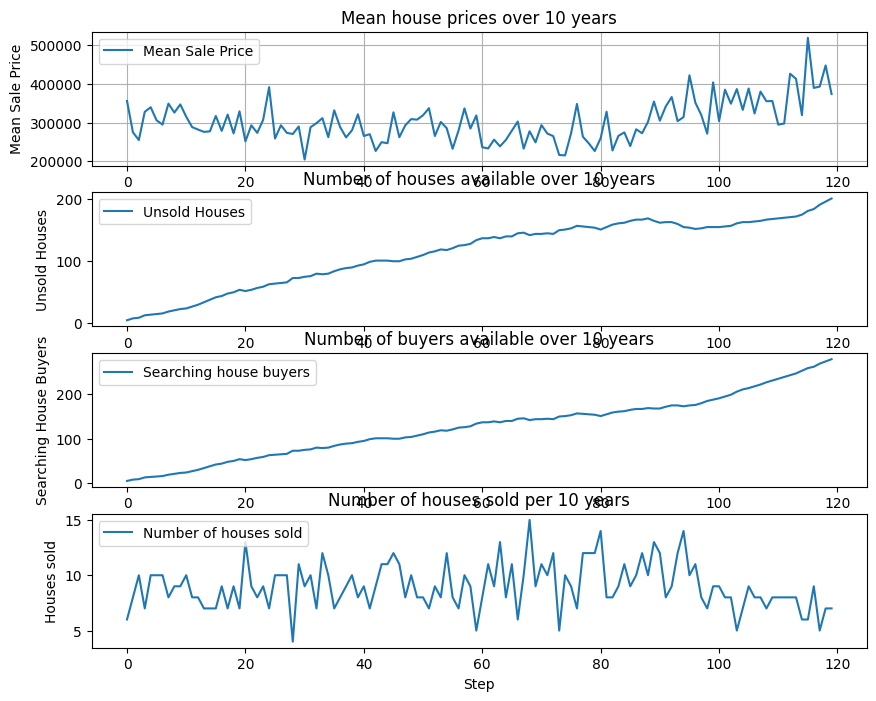

In [72]:
model = House_Model(number_of_buyers = 0, number_of_sellers = 3000, seed = None, interest_rate = INTEREST_RATE[0])

for i in range(10*12):
    print(i)
    model.step(interest_rate_step = INTEREST_RATE[i], inflation = INFLATON[i] / 12)

results = [model.Mean_Sale_Prices, model.Unsold_houses, model.Number_of_buyers, model.Number_of_houses_sold]

plt.figure(figsize = (10, 8))

plt.subplot(411)
plt.plot(results[0], label = 'Mean Sale Price')
plt.title("Mean house prices over 10 years")
plt.xlabel('Step')
plt.ylabel('Mean Sale Price')
plt.grid(True)
plt.legend()

plt.subplot(412)
plt.title("Number of houses available over 10 years")
plt.plot(results[1], label = 'Unsold Houses')
plt.xlabel('Step')
plt.ylabel('Unsold Houses')
plt.legend()

plt.subplot(413)
plt.title("Number of buyers available over 10 years")
plt.plot(results[2], label = 'Searching house buyers')
plt.xlabel('Step')
plt.ylabel('Searching House Buyers')
plt.legend()

plt.subplot(414)
plt.title("Number of houses sold per 10 years")
plt.plot(results[3], label = 'Number of houses sold')
plt.xlabel('Step')
plt.ylabel('Houses sold')
plt.legend()

plt.show()

Compare simulation with the real data

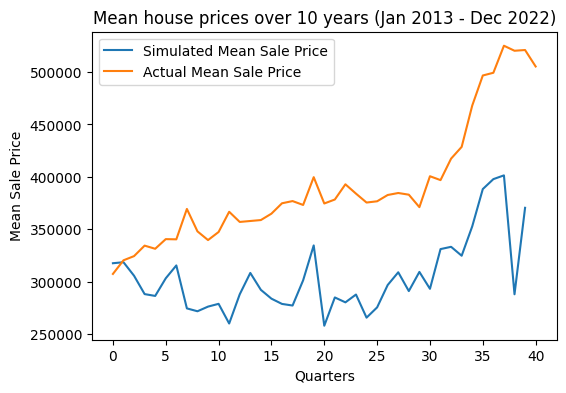

In [70]:
plt.figure(figsize = (6, 4))

controle = pd.read_csv("AVG_house_price.csv")
controle2 = controle["ASPUS"]

def results_to_per_querter(results):
    ds_results = []
    sum_var = 0
    for i in range(len(results[0])):
        sum_var += results[0][i]
        if (i + 1) % 3 == 0:
            ds_results.append(sum_var / 3)
            sum_var = 0
    return ds_results

result_per_qt = results_to_per_querter(results)
plt.plot(result_per_qt, label = 'Simulated Mean Sale Price')
plt.plot(controle2, label = 'Actual Mean Sale Price')
plt.title("Mean house prices over 10 years (Jan 2013 - Dec 2022)")
plt.xlabel('Quarters')
plt.ylabel('Mean Sale Price')
plt.legend()
plt.show()
plt.close()

Simulations with different interest rates

In [216]:
# interest rate lists for testing the effect of interest rates
INTEREST_RATE_1P_CONST = [1 for _ in range(120)]
INTEREST_RATE_2P_CONST = [2 for _ in range(120)]
INTEREST_RATE_3P_CONST = [3 for _ in range(120)]
INTEREST_RATE_4P_CONST = [4 for _ in range(120)]
INTEREST_RATE_5P_CONST = [5 for _ in range(120)]

Turn 2: Buyers=257, Sellers=257, Demand/Supply=1.0
Inflation Factor: 1.0143815008708332, total inflation = 1.00010172449
Average Buyer Budget: 312512.2568717844
Mean Sale Price: 292552.2618955927
Turn 3: Buyers=404, Sellers=404, Demand/Supply=1.0
Inflation Factor: 1.0143815008708332, total inflation = 1.0002034593278717
Average Buyer Budget: 294653.09678812505
Mean Sale Price: 302778.19975136017
Turn 4: Buyers=512, Sellers=512, Demand/Supply=1.0
Inflation Factor: 1.0143815008708332, total inflation = 1.0003052045146679
Average Buyer Budget: 276080.1479899157
Mean Sale Price: 308543.19086247147
Turn 5: Buyers=608, Sellers=608, Demand/Supply=1.0
Inflation Factor: 1.0143815008708332, total inflation = 1.0004069600514414
Average Buyer Budget: 256452.01218058003
Mean Sale Price: 326384.2348054437
Turn 6: Buyers=678, Sellers=678, Demand/Supply=1.0
Inflation Factor: 1.0143815008708332, total inflation = 1.000508725939245
Average Buyer Budget: 239063.67012435646
Mean Sale Price: 324678.1161534

Turn 43: Buyers=2625, Sellers=2625, Demand/Supply=1.0
Inflation Factor: 1.0129641652964698, total inflation = 1.0032020158566295
Average Buyer Budget: 149193.47465876758
Mean Sale Price: 329643.1857525664
Turn 44: Buyers=2655, Sellers=2655, Demand/Supply=1.0
Inflation Factor: 1.0129641652964698, total inflation = 1.0032899063299232
Average Buyer Budget: 150130.31442586932
Mean Sale Price: 335753.25760266767
Turn 45: Buyers=2681, Sellers=2681, Demand/Supply=1.0
Inflation Factor: 1.0129641652964698, total inflation = 1.0033778045032964
Average Buyer Budget: 152575.65112686402
Mean Sale Price: 329519.53632328945
Turn 46: Buyers=2692, Sellers=2692, Demand/Supply=1.0
Inflation Factor: 1.0129641652964698, total inflation = 1.0034657103774236
Average Buyer Budget: 152322.24533790888
Mean Sale Price: 335146.87925762346
Turn 47: Buyers=2700, Sellers=2700, Demand/Supply=1.0
Inflation Factor: 1.0129641652964698, total inflation = 1.0035536239529796
Average Buyer Budget: 152019.39371393074
Mean Sa

Turn 84: Buyers=3083, Sellers=3083, Demand/Supply=1.0
Inflation Factor: 1.0168038954882812, total inflation = 1.008956926199174
Average Buyer Budget: 164815.1174557189
Mean Sale Price: 358133.0809630318
Turn 85: Buyers=3077, Sellers=3077, Demand/Supply=1.0
Inflation Factor: 1.0168038954882812, total inflation = 1.0090839013315975
Average Buyer Budget: 166253.20825881904
Mean Sale Price: 372315.09653301904
Turn 86: Buyers=3087, Sellers=3087, Demand/Supply=1.0
Inflation Factor: 1.012768918965162, total inflation = 1.009170345092357
Average Buyer Budget: 166511.94817915483
Mean Sale Price: 387197.5668881224
Turn 87: Buyers=3071, Sellers=3071, Demand/Supply=1.0
Inflation Factor: 1.012768918965162, total inflation = 1.0092567962583716
Average Buyer Budget: 166275.42354944226
Mean Sale Price: 373262.0715130112
Turn 88: Buyers=3060, Sellers=3060, Demand/Supply=1.0
Inflation Factor: 1.012768918965162, total inflation = 1.0093432548302759
Average Buyer Budget: 165977.55537306212
Mean Sale Price

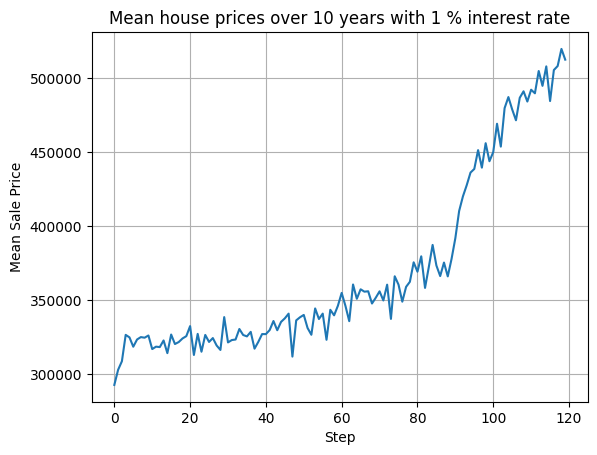

In [217]:
model2 = House_Model(number_of_buyers = 0, number_of_sellers = 122400, seed = None, interest_rate = INTEREST_RATE_1P_CONST[0])

for i in range(10*12):
    #print("check", i)
    model2.step(interest_rate_step = INTEREST_RATE_1P_CONST[i], inflation = INFLATON[i] / 12)

results2 = [model2.Mean_Sale_Prices, model2.Unsold_houses, model2.Number_of_buyers, model2.Number_of_houses_sold]

plt.plot(results2[0], label = 'Mean Sale Price')
plt.title("Mean house prices over 10 years with 1 % interest rate")
plt.xlabel('Step')
plt.ylabel('Mean Sale Price')
plt.grid(True)
plt.show()
plt.close()

Turn 2: Buyers=261, Sellers=261, Demand/Supply=1.0
Inflation Factor: 1.0143815008708332, total inflation = 1.00010172449
Average Buyer Budget: 270774.1113465831
Mean Sale Price: 289933.73311756254
Turn 3: Buyers=430, Sellers=430, Demand/Supply=1.0
Inflation Factor: 1.0143815008708332, total inflation = 1.0002034593278717
Average Buyer Budget: 237546.35600044942
Mean Sale Price: 315648.0499916578
Turn 4: Buyers=554, Sellers=554, Demand/Supply=1.0
Inflation Factor: 1.0143815008708332, total inflation = 1.0003052045146679
Average Buyer Budget: 225848.40381013262
Mean Sale Price: 314401.90141392744
Turn 5: Buyers=659, Sellers=659, Demand/Supply=1.0
Inflation Factor: 1.0143815008708332, total inflation = 1.0004069600514414
Average Buyer Budget: 204268.38587456688
Mean Sale Price: 313421.5732193774
Turn 6: Buyers=736, Sellers=736, Demand/Supply=1.0
Inflation Factor: 1.0143815008708332, total inflation = 1.000508725939245
Average Buyer Budget: 189387.87968261263
Mean Sale Price: 311341.118124

Turn 43: Buyers=3391, Sellers=3391, Demand/Supply=1.0
Inflation Factor: 1.0129641652964698, total inflation = 1.0032020158566295
Average Buyer Budget: 132754.4290383796
Mean Sale Price: 318260.765308081
Turn 44: Buyers=3434, Sellers=3434, Demand/Supply=1.0
Inflation Factor: 1.0129641652964698, total inflation = 1.0032899063299232
Average Buyer Budget: 131834.87140317
Mean Sale Price: 322090.90548493754
Turn 45: Buyers=3464, Sellers=3464, Demand/Supply=1.0
Inflation Factor: 1.0129641652964698, total inflation = 1.0033778045032964
Average Buyer Budget: 132542.4651672498
Mean Sale Price: 314108.11072002724
Turn 46: Buyers=3502, Sellers=3502, Demand/Supply=1.0
Inflation Factor: 1.0129641652964698, total inflation = 1.0034657103774236
Average Buyer Budget: 132413.18293117496
Mean Sale Price: 333871.8332229633
Turn 47: Buyers=3522, Sellers=3522, Demand/Supply=1.0
Inflation Factor: 1.0129641652964698, total inflation = 1.0035536239529796
Average Buyer Budget: 131865.60513560163
Mean Sale Pric

Turn 84: Buyers=4303, Sellers=4303, Demand/Supply=1.0
Inflation Factor: 1.0168038954882812, total inflation = 1.008956926199174
Average Buyer Budget: 144378.48972290408
Mean Sale Price: 343918.0498027255
Turn 85: Buyers=4316, Sellers=4316, Demand/Supply=1.0
Inflation Factor: 1.0168038954882812, total inflation = 1.0090839013315975
Average Buyer Budget: 145192.5973800909
Mean Sale Price: 351582.2766466604
Turn 86: Buyers=4338, Sellers=4338, Demand/Supply=1.0
Inflation Factor: 1.012768918965162, total inflation = 1.009170345092357
Average Buyer Budget: 146565.75470111117
Mean Sale Price: 358646.88370580296
Turn 87: Buyers=4317, Sellers=4317, Demand/Supply=1.0
Inflation Factor: 1.012768918965162, total inflation = 1.0092567962583716
Average Buyer Budget: 144432.43454312705
Mean Sale Price: 370379.0937341077
Turn 88: Buyers=4316, Sellers=4316, Demand/Supply=1.0
Inflation Factor: 1.012768918965162, total inflation = 1.0093432548302759
Average Buyer Budget: 146298.11572408795
Mean Sale Price

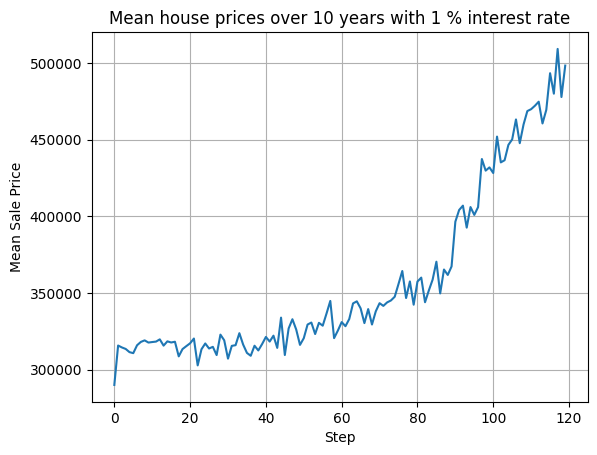

In [218]:
model3 = House_Model(number_of_buyers = 0, number_of_sellers = 122400, seed = None, interest_rate = INTEREST_RATE_2P_CONST[0])

for i in range(10*12):
    #print("check", i)
    model3.step(interest_rate_step = INTEREST_RATE_2P_CONST[i], inflation = INFLATON[i] / 12)

results3 = [model3.Mean_Sale_Prices, model3.Unsold_houses, model3.Number_of_buyers, model3.Number_of_houses_sold]

plt.plot(results3[0], label = 'Mean Sale Price')
plt.title("Mean house prices over 10 years with 1 % interest rate")
plt.xlabel('Step')
plt.ylabel('Mean Sale Price')
plt.grid(True)
plt.show()
plt.close()

Turn 2: Buyers=54, Sellers=54, Demand/Supply=1.0
Inflation Factor: 1.0143815008708332, total inflation = 1.00010172449
Average Buyer Budget: 204915.60536752132
Mean Sale Price: 264094.90359531826
Turn 3: Buyers=93, Sellers=93, Demand/Supply=1.0
Inflation Factor: 1.0143815008708332, total inflation = 1.0002034593278717
Average Buyer Budget: 201233.33528425978
Mean Sale Price: 278756.1799850739
Turn 4: Buyers=121, Sellers=121, Demand/Supply=1.0
Inflation Factor: 1.0143815008708332, total inflation = 1.0003052045146679
Average Buyer Budget: 185867.1695477559
Mean Sale Price: 322139.14353392966
Turn 5: Buyers=137, Sellers=137, Demand/Supply=1.0
Inflation Factor: 1.0143815008708332, total inflation = 1.0004069600514414
Average Buyer Budget: 165293.3062792602
Mean Sale Price: 302795.002907465
Turn 6: Buyers=171, Sellers=171, Demand/Supply=1.0
Inflation Factor: 1.0143815008708332, total inflation = 1.000508725939245
Average Buyer Budget: 138117.8314430311
Mean Sale Price: 307851.48801878566
T

Turn 43: Buyers=878, Sellers=878, Demand/Supply=1.0
Inflation Factor: 1.0129641652964698, total inflation = 1.0032020158566295
Average Buyer Budget: 121243.7930652642
Mean Sale Price: 279339.6201566387
Turn 44: Buyers=900, Sellers=900, Demand/Supply=1.0
Inflation Factor: 1.0129641652964698, total inflation = 1.0032899063299232
Average Buyer Budget: 121124.03367000709
Mean Sale Price: 308873.5307009231
Turn 45: Buyers=919, Sellers=919, Demand/Supply=1.0
Inflation Factor: 1.0129641652964698, total inflation = 1.0033778045032964
Average Buyer Budget: 124359.20208965304
Mean Sale Price: 287120.50026426744
Turn 46: Buyers=925, Sellers=925, Demand/Supply=1.0
Inflation Factor: 1.0129641652964698, total inflation = 1.0034657103774236
Average Buyer Budget: 121929.98101596595
Mean Sale Price: 305470.49225649436
Turn 47: Buyers=931, Sellers=931, Demand/Supply=1.0
Inflation Factor: 1.0129641652964698, total inflation = 1.0035536239529796
Average Buyer Budget: 122923.20993128228
Mean Sale Price: 31

Turn 84: Buyers=1195, Sellers=1195, Demand/Supply=1.0
Inflation Factor: 1.0168038954882812, total inflation = 1.008956926199174
Average Buyer Budget: 132287.82437449772
Mean Sale Price: 312360.75521016284
Turn 85: Buyers=1215, Sellers=1215, Demand/Supply=1.0
Inflation Factor: 1.0168038954882812, total inflation = 1.0090839013315975
Average Buyer Budget: 133647.25657812436
Mean Sale Price: 317959.64887867094
Turn 86: Buyers=1217, Sellers=1217, Demand/Supply=1.0
Inflation Factor: 1.012768918965162, total inflation = 1.009170345092357
Average Buyer Budget: 133919.22554420275
Mean Sale Price: 307719.8509019389
Turn 87: Buyers=1222, Sellers=1222, Demand/Supply=1.0
Inflation Factor: 1.012768918965162, total inflation = 1.0092567962583716
Average Buyer Budget: 133657.0738631805
Mean Sale Price: 320163.42318006424
Turn 88: Buyers=1232, Sellers=1232, Demand/Supply=1.0
Inflation Factor: 1.012768918965162, total inflation = 1.0093432548302759
Average Buyer Budget: 134063.3046600623
Mean Sale Pric

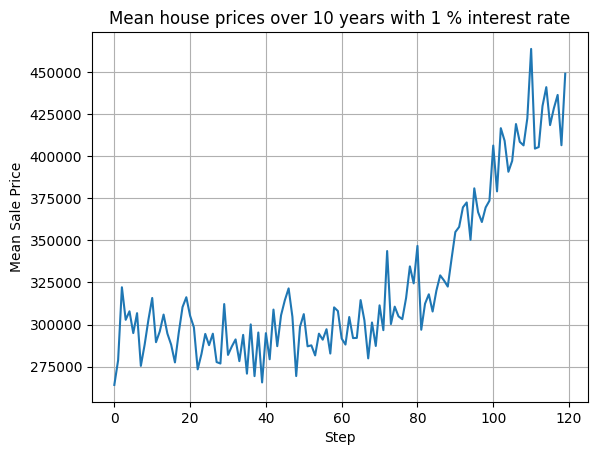

In [223]:
model4 = House_Model(number_of_buyers = 0, number_of_sellers = 12240 * 2, seed = None, interest_rate = INTEREST_RATE_3P_CONST[0])

for i in range(10*12):
    #print("check", i)
    model4.step(interest_rate_step = INTEREST_RATE_3P_CONST[i], inflation = INFLATON[i] / 12)

results4 = [model4.Mean_Sale_Prices, model4.Unsold_houses, model4.Number_of_buyers, model4.Number_of_houses_sold]

plt.plot(results4[0], label = 'Mean Sale Price')
plt.title("Mean house prices over 10 years with 1 % interest rate")
plt.xlabel('Step')
plt.ylabel('Mean Sale Price')
plt.grid(True)
plt.show()
plt.close()

Turn 2: Buyers=51, Sellers=51, Demand/Supply=1.0
Inflation Factor: 1.0143815008708332, total inflation = 1.00010172449
Average Buyer Budget: 236932.94897444473
Mean Sale Price: 259601.0692917269
Turn 3: Buyers=84, Sellers=84, Demand/Supply=1.0
Inflation Factor: 1.0143815008708332, total inflation = 1.0002034593278717
Average Buyer Budget: 204520.89544891397
Mean Sale Price: 280176.10720474715
Turn 4: Buyers=115, Sellers=115, Demand/Supply=1.0
Inflation Factor: 1.0143815008708332, total inflation = 1.0003052045146679
Average Buyer Budget: 148231.8288545572
Mean Sale Price: 301871.4218966807
Turn 5: Buyers=152, Sellers=152, Demand/Supply=1.0
Inflation Factor: 1.0143815008708332, total inflation = 1.0004069600514414
Average Buyer Budget: 144490.84755176512
Mean Sale Price: 293281.22802986123
Turn 6: Buyers=179, Sellers=179, Demand/Supply=1.0
Inflation Factor: 1.0143815008708332, total inflation = 1.000508725939245
Average Buyer Budget: 134641.46257617304
Mean Sale Price: 284831.7328718469

Turn 43: Buyers=1025, Sellers=1025, Demand/Supply=1.0
Inflation Factor: 1.0129641652964698, total inflation = 1.0032020158566295
Average Buyer Budget: 111296.10077321585
Mean Sale Price: 299487.63289011933
Turn 44: Buyers=1049, Sellers=1049, Demand/Supply=1.0
Inflation Factor: 1.0129641652964698, total inflation = 1.0032899063299232
Average Buyer Budget: 113112.0631268655
Mean Sale Price: 285178.15614298143
Turn 45: Buyers=1056, Sellers=1056, Demand/Supply=1.0
Inflation Factor: 1.0129641652964698, total inflation = 1.0033778045032964
Average Buyer Budget: 112427.56724736007
Mean Sale Price: 268955.5464536031
Turn 46: Buyers=1082, Sellers=1082, Demand/Supply=1.0
Inflation Factor: 1.0129641652964698, total inflation = 1.0034657103774236
Average Buyer Budget: 112116.53015517128
Mean Sale Price: 285488.5029051781
Turn 47: Buyers=1108, Sellers=1108, Demand/Supply=1.0
Inflation Factor: 1.0129641652964698, total inflation = 1.0035536239529796
Average Buyer Budget: 112346.10371166
Mean Sale Pr

Turn 84: Buyers=1492, Sellers=1492, Demand/Supply=1.0
Inflation Factor: 1.0168038954882812, total inflation = 1.008956926199174
Average Buyer Budget: 121458.11525082057
Mean Sale Price: 295647.3716593664
Turn 85: Buyers=1506, Sellers=1506, Demand/Supply=1.0
Inflation Factor: 1.0168038954882812, total inflation = 1.0090839013315975
Average Buyer Budget: 121974.79276185168
Mean Sale Price: 304030.5712760234
Turn 86: Buyers=1512, Sellers=1512, Demand/Supply=1.0
Inflation Factor: 1.012768918965162, total inflation = 1.009170345092357
Average Buyer Budget: 122555.24545982425
Mean Sale Price: 318637.42389828205
Turn 87: Buyers=1517, Sellers=1517, Demand/Supply=1.0
Inflation Factor: 1.012768918965162, total inflation = 1.0092567962583716
Average Buyer Budget: 123404.44462504258
Mean Sale Price: 291235.7401068352
Turn 88: Buyers=1523, Sellers=1523, Demand/Supply=1.0
Inflation Factor: 1.012768918965162, total inflation = 1.0093432548302759
Average Buyer Budget: 123281.5765770746
Mean Sale Price

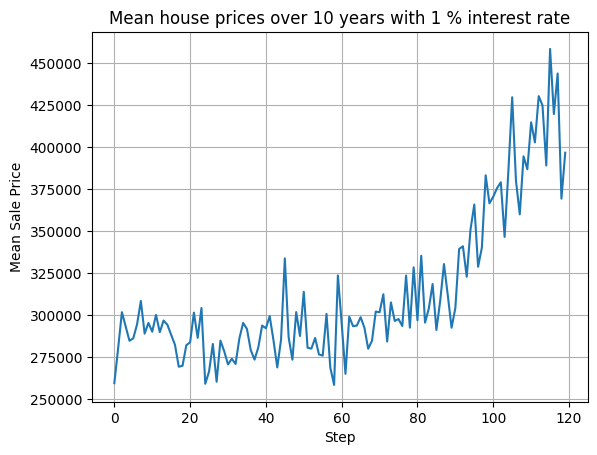

In [222]:
model5 = House_Model(number_of_buyers = 0, number_of_sellers = 12240 * 2, seed = None, interest_rate = INTEREST_RATE_4P_CONST[0])

for i in range(10*12):
    #print("check", i)
    model5.step(interest_rate_step = INTEREST_RATE_4P_CONST[i], inflation = INFLATON[i] / 12)

results5 = [model5.Mean_Sale_Prices, model5.Unsold_houses, model5.Number_of_buyers, model5.Number_of_houses_sold]

plt.plot(results5[0], label = 'Mean Sale Price')
plt.title("Mean house prices over 10 years with 1 % interest rate")
plt.xlabel('Step')
plt.ylabel('Mean Sale Price')
plt.grid(True)
plt.show()
plt.close()

Turn 2: Buyers=135, Sellers=135, Demand/Supply=1.0
Inflation Factor: 1.0143815008708332, total inflation = 1.00010172449
Average Buyer Budget: 180696.2221355786
Mean Sale Price: 249391.28379178955
Turn 3: Buyers=237, Sellers=237, Demand/Supply=1.0
Inflation Factor: 1.0143815008708332, total inflation = 1.0002034593278717
Average Buyer Budget: 163295.2962432847
Mean Sale Price: 261111.2311892146
Turn 4: Buyers=327, Sellers=327, Demand/Supply=1.0
Inflation Factor: 1.0143815008708332, total inflation = 1.0003052045146679
Average Buyer Budget: 138806.9154781897
Mean Sale Price: 299254.44668724824
Turn 5: Buyers=408, Sellers=408, Demand/Supply=1.0
Inflation Factor: 1.0143815008708332, total inflation = 1.0004069600514414
Average Buyer Budget: 129689.84220765873
Mean Sale Price: 284689.7908114175
Turn 6: Buyers=490, Sellers=490, Demand/Supply=1.0
Inflation Factor: 1.0143815008708332, total inflation = 1.000508725939245
Average Buyer Budget: 126188.03459067413
Mean Sale Price: 285807.58451542

Turn 43: Buyers=2829, Sellers=2829, Demand/Supply=1.0
Inflation Factor: 1.0129641652964698, total inflation = 1.0032020158566295
Average Buyer Budget: 100753.96207964273
Mean Sale Price: 285829.52909934515
Turn 44: Buyers=2869, Sellers=2869, Demand/Supply=1.0
Inflation Factor: 1.0129641652964698, total inflation = 1.0032899063299232
Average Buyer Budget: 100903.17936014914
Mean Sale Price: 299504.02343277616
Turn 45: Buyers=2912, Sellers=2912, Demand/Supply=1.0
Inflation Factor: 1.0129641652964698, total inflation = 1.0033778045032964
Average Buyer Budget: 100872.98916040114
Mean Sale Price: 279092.9528096548
Turn 46: Buyers=2958, Sellers=2958, Demand/Supply=1.0
Inflation Factor: 1.0129641652964698, total inflation = 1.0034657103774236
Average Buyer Budget: 101193.91906351401
Mean Sale Price: 283987.34230857244
Turn 47: Buyers=3000, Sellers=3000, Demand/Supply=1.0
Inflation Factor: 1.0129641652964698, total inflation = 1.0035536239529796
Average Buyer Budget: 101465.90063459714
Mean Sa

Turn 84: Buyers=4325, Sellers=4325, Demand/Supply=1.0
Inflation Factor: 1.0168038954882812, total inflation = 1.008956926199174
Average Buyer Budget: 111498.91158825353
Mean Sale Price: 310251.7228872569
Turn 85: Buyers=4358, Sellers=4358, Demand/Supply=1.0
Inflation Factor: 1.0168038954882812, total inflation = 1.0090839013315975
Average Buyer Budget: 111415.06126255848
Mean Sale Price: 324973.6906653734
Turn 86: Buyers=4387, Sellers=4387, Demand/Supply=1.0
Inflation Factor: 1.012768918965162, total inflation = 1.009170345092357
Average Buyer Budget: 111544.76491692757
Mean Sale Price: 329991.2122990772
Turn 87: Buyers=4401, Sellers=4401, Demand/Supply=1.0
Inflation Factor: 1.012768918965162, total inflation = 1.0092567962583716
Average Buyer Budget: 111674.11698322713
Mean Sale Price: 298940.5300655265
Turn 88: Buyers=4433, Sellers=4433, Demand/Supply=1.0
Inflation Factor: 1.012768918965162, total inflation = 1.0093432548302759
Average Buyer Budget: 112239.8673519591
Mean Sale Price:

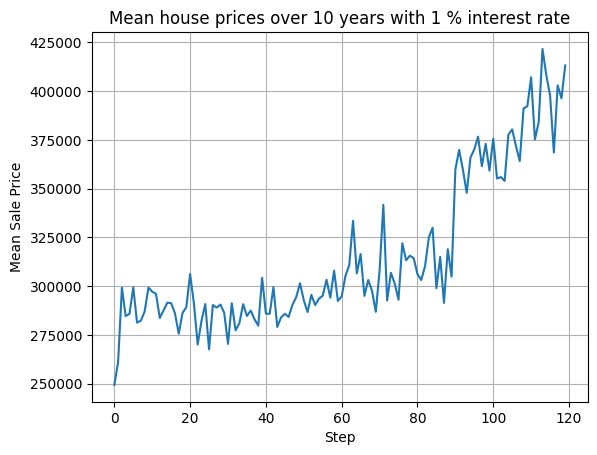

In [220]:
model6 = House_Model(number_of_buyers = 0, number_of_sellers = 12240 * 5, seed = None, interest_rate = INTEREST_RATE_5P_CONST[0])

for i in range(10*12):
    #print("check", i)
    model6.step(interest_rate_step = INTEREST_RATE_5P_CONST[i], inflation = INFLATON[i] / 12)

results6 = [model6.Mean_Sale_Prices, model6.Unsold_houses, model6.Number_of_buyers, model6.Number_of_houses_sold]

plt.plot(results6[0], label = 'Mean Sale Price')
plt.title("Mean house prices over 10 years with 1 % interest rate")
plt.xlabel('Step')
plt.ylabel('Mean Sale Price')
plt.grid(True)
plt.show()
plt.close()

Comparing results of different simulations

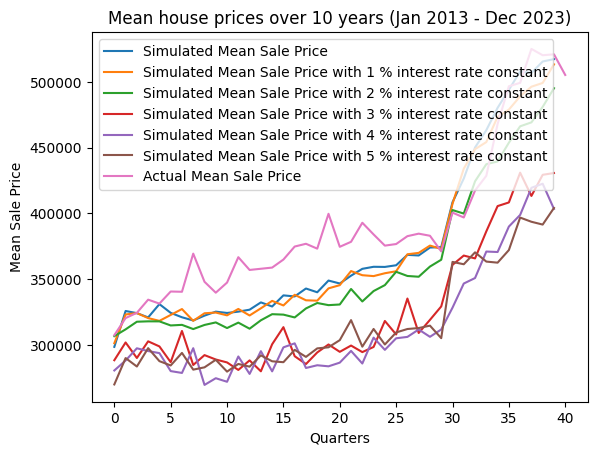

In [224]:
# change results per onth to results per querter to compare it with original data
results_per_qt1 = results_to_per_querter(results)
results_per_qt2 = results_to_per_querter(results2)
results_per_qt3 = results_to_per_querter(results3)
results_per_qt4 = results_to_per_querter(results4)
results_per_qt5 = results_to_per_querter(results5)
results_per_qt6 = results_to_per_querter(results6)

plt.plot(results_per_qt1, label = 'Simulated Mean Sale Price')
plt.plot(results_per_qt2, label = 'Simulated Mean Sale Price with 1 % interest rate constant')
plt.plot(results_per_qt3, label = 'Simulated Mean Sale Price with 2 % interest rate constant')
plt.plot(results_per_qt4, label = 'Simulated Mean Sale Price with 3 % interest rate constant')
plt.plot(results_per_qt5, label = 'Simulated Mean Sale Price with 4 % interest rate constant')
plt.plot(results_per_qt6, label = 'Simulated Mean Sale Price with 5 % interest rate constant')
plt.plot(controle2, label = 'Actual Mean Sale Price')
plt.title("Mean house prices over 10 years (Jan 2013 - Dec 2023)")
plt.xlabel('Quarters')
plt.ylabel('Mean Sale Price')
plt.legend()
plt.show()
plt.close()

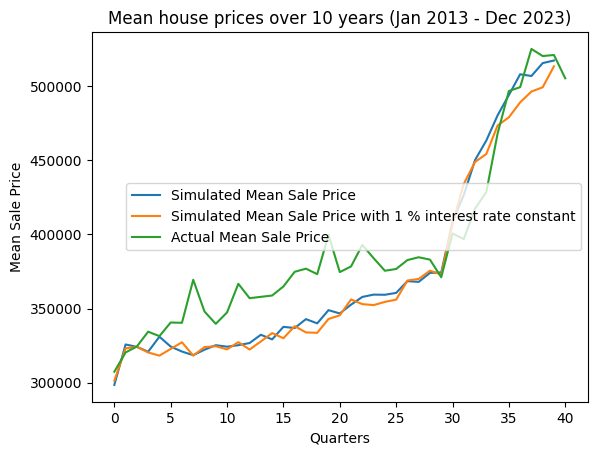

In [225]:
#more clear picture
plt.plot(results_per_qt1, label = 'Simulated Mean Sale Price')
plt.plot(results_per_qt2, label = 'Simulated Mean Sale Price with 1 % interest rate constant')
plt.plot(controle2, label = 'Actual Mean Sale Price')
plt.title("Mean house prices over 10 years (Jan 2013 - Dec 2023)")
plt.xlabel('Quarters')
plt.ylabel('Mean Sale Price')
plt.legend()
plt.show()
plt.close()

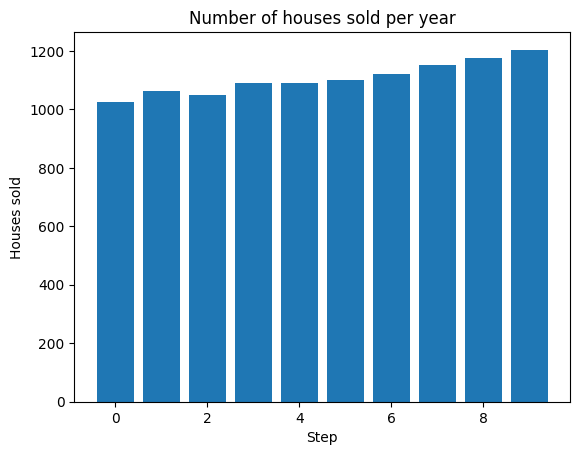

In [25]:
#bar plot for number of houses sold

house_sold_per_year = [0 for _ in range(10)]
for i in range(10):
    for j in range(12):
        house_sold_per_year[i] += results[3][(i + 1) * j] 

plt.bar([i for i in range(10)], house_sold_per_year)
plt.title("Number of houses sold per year")
plt.xlabel('Step')
plt.ylabel('Houses sold')
plt.show()
plt.close()

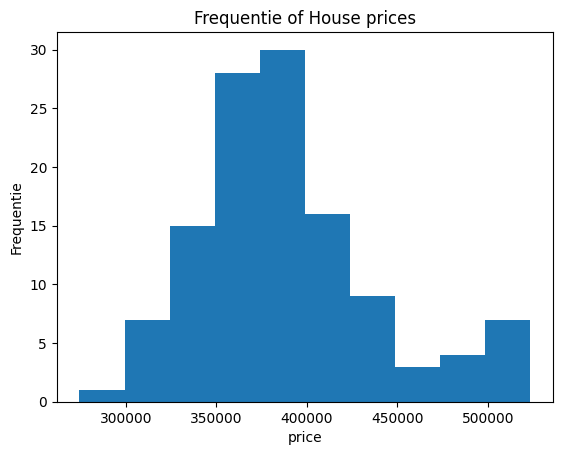

In [26]:
plt.hist(results[0])
plt.title("Frequentie of House prices")
plt.xlabel("price")
plt.ylabel("Frequentie")
plt.show()
plt.close()

Real data graphs are below

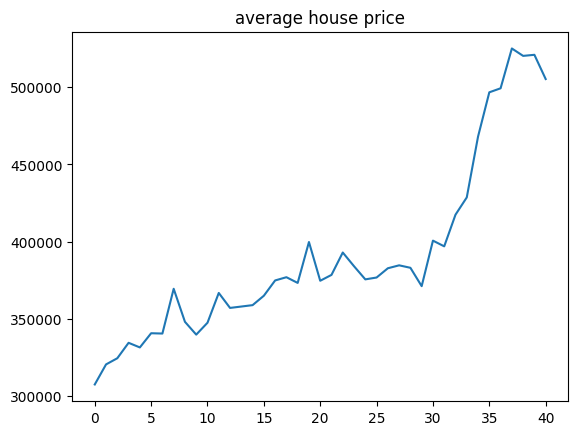

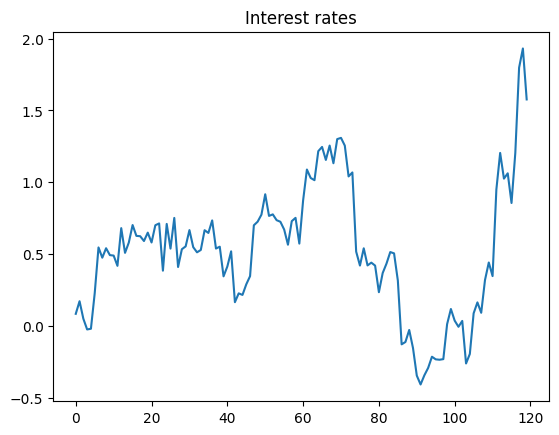

In [27]:
#check
controle = pd.read_csv("AVG_house_price.csv")
controle2 = controle["ASPUS"]
plt.plot(controle2)
plt.title("average house price")
plt.show()
plt.close()
plt.plot(df3)
plt.title("Interest rates")
plt.show()
plt.close()

In [28]:
#check
controle = pd.read_csv("MSPUS.csv")
controle2 = controle["MSPUS"]
plt.plot(controle2)
plt.title("median house price")
plt.show()
plt.close()
plt.plot(df3)
plt.title("Interest rates")
plt.show()
plt.close()

FileNotFoundError: [Errno 2] No such file or directory: 'MSPUS.csv'

More options:

- Agents don't always buy a house in the next time step (chance) and they have a chance to step out of the market (renting for example)
- Budget and willingness to pay is based on factors like age and family size instead of random
- Agents are able to save money (increase budget) when not buying a house
- Agents who already have a house have a chance of of selling and a chance of buying a new house
- Different kind of houses that different people have preferences for

More visualizations:

- Average time to sell a house.
- Proportion of homeless people.
- Total transaction volume per step.
- Histogram of house prices.